In [1]:
import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l1_l2 as l1l2
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [5]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [8]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               803600    
Total para

In [10]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
__________

In [11]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`


In [12]:
dLosses = []
gLosses = []

In [13]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

In [14]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [15]:
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

In [16]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount
    plotGeneratedImages(0)
    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 50
Batch size: 128
Batches per epoch: 468


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:38, 12.08it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:38, 12.03it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:37, 12.26it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:37, 12.27it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:38, 12.13it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:38, 12.22it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:37, 12.43it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:38, 12.13it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:39, 11.94it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:37, 12.51it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:37, 12.37it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:39, 11.94it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:37, 12.40it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:37, 12.50it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:37, 12.50it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:38, 12.22it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:38, 12.08it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:37, 12.53it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:39, 11.81it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:37, 12.44it/s]

--------------- Epoch 21 ---------------


  0%|          | 1/468 [00:00<00:48,  9.62it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:36, 12.74it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:37, 12.58it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:37, 12.49it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:37, 12.42it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:36, 12.60it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:37, 12.59it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:36, 12.61it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:37, 12.44it/s]

--------------- Epoch 30 ---------------


  0%|          | 2/468 [00:00<00:36, 12.70it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:37, 12.54it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:37, 12.28it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:37, 12.33it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:43, 10.61it/s]

--------------- Epoch 35 ---------------


  0%|          | 2/468 [00:00<00:37, 12.47it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:38, 12.13it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:37, 12.37it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:37, 12.49it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:37, 12.48it/s]

--------------- Epoch 40 ---------------


  0%|          | 2/468 [00:00<00:40, 11.61it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:37, 12.42it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:40, 11.55it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:37, 12.41it/s]

--------------- Epoch 45 ---------------


  0%|          | 2/468 [00:00<00:36, 12.76it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:40, 11.37it/s]

--------------- Epoch 47 ---------------


  9%|▉         | 42/468 [00:03<00:36, 11.53it/s]


KeyboardInterrupt: 

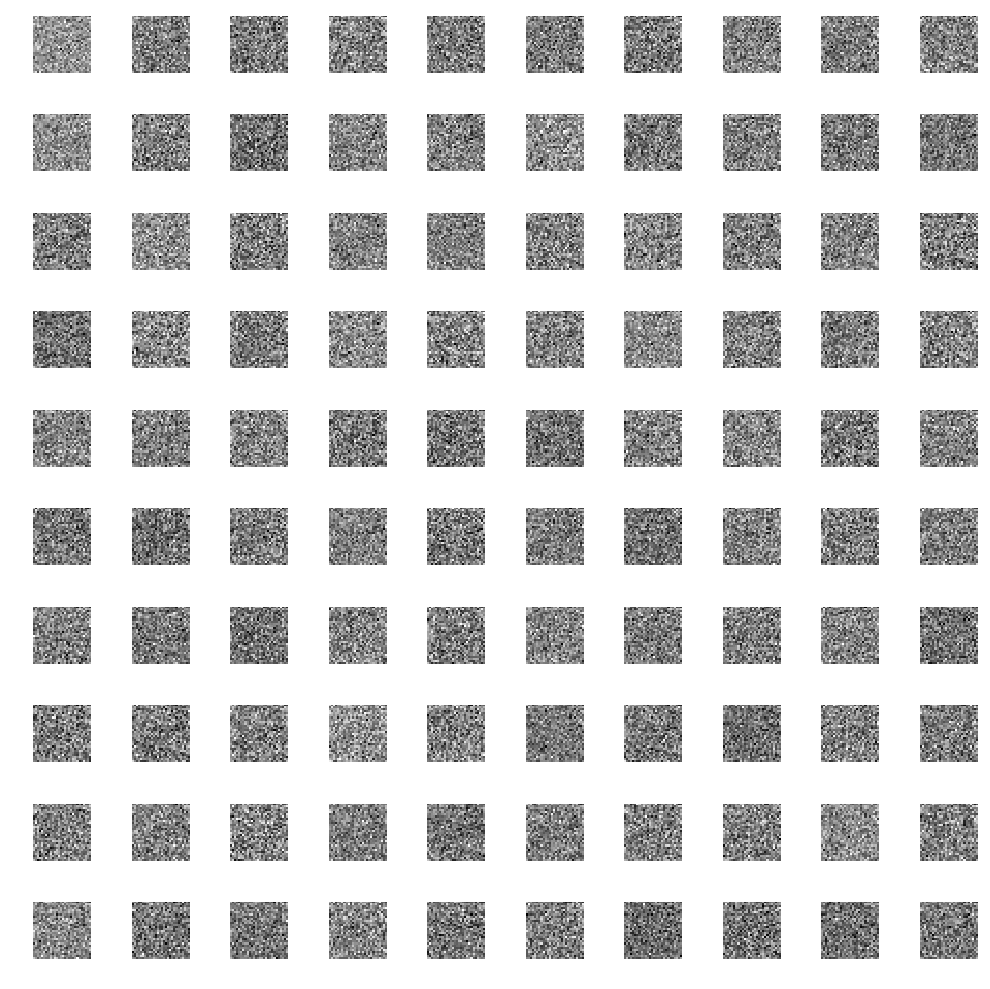

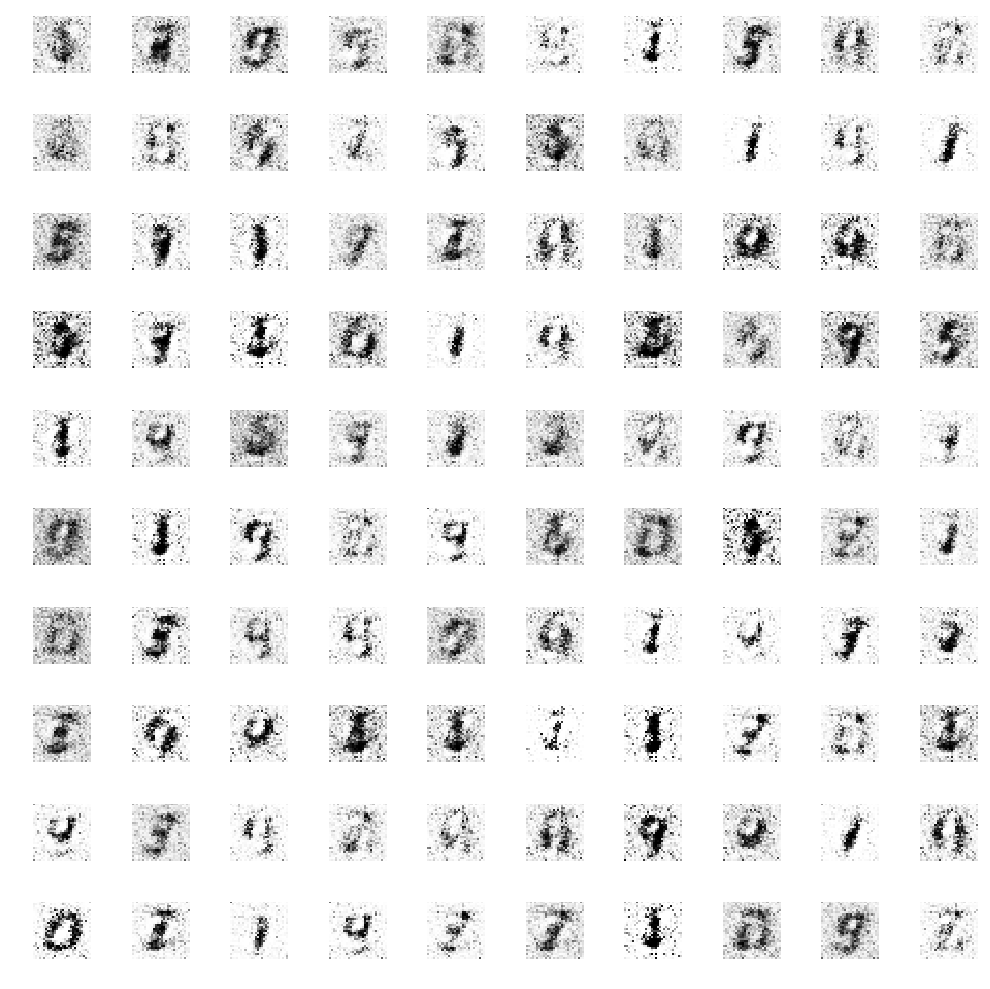

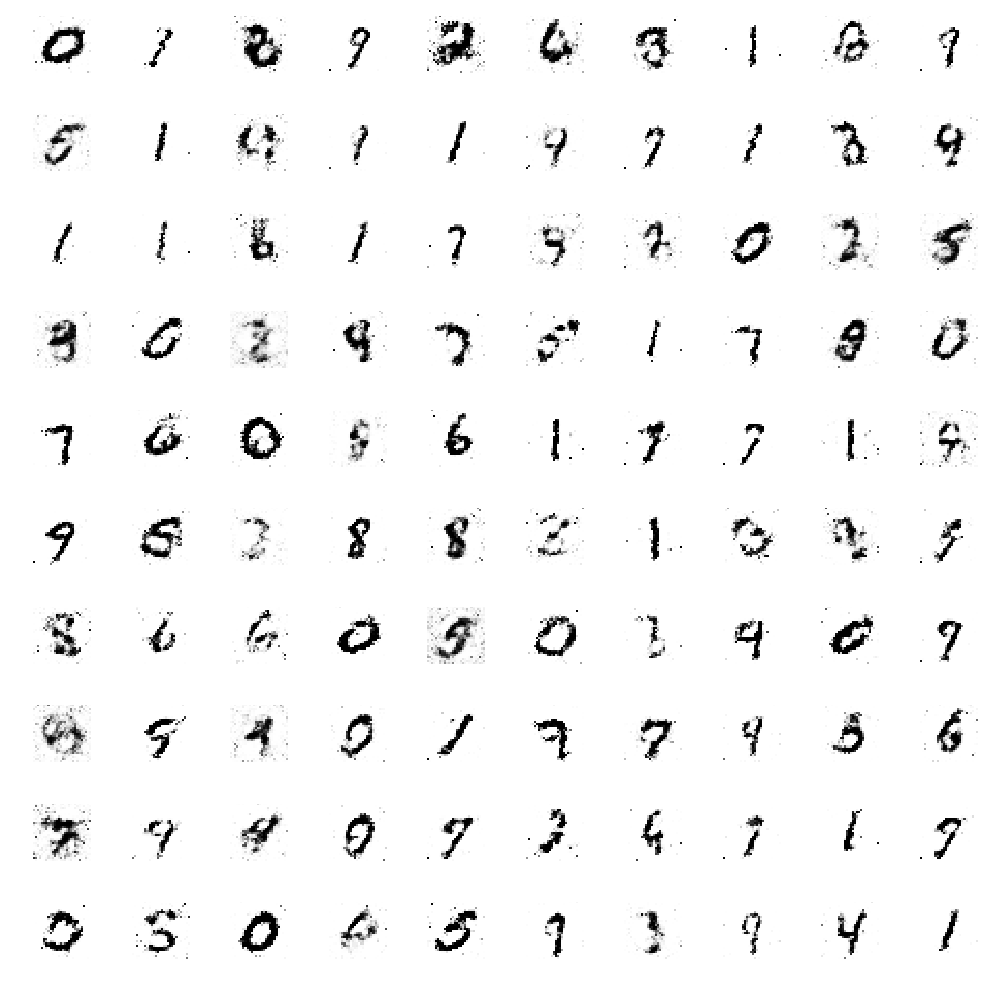

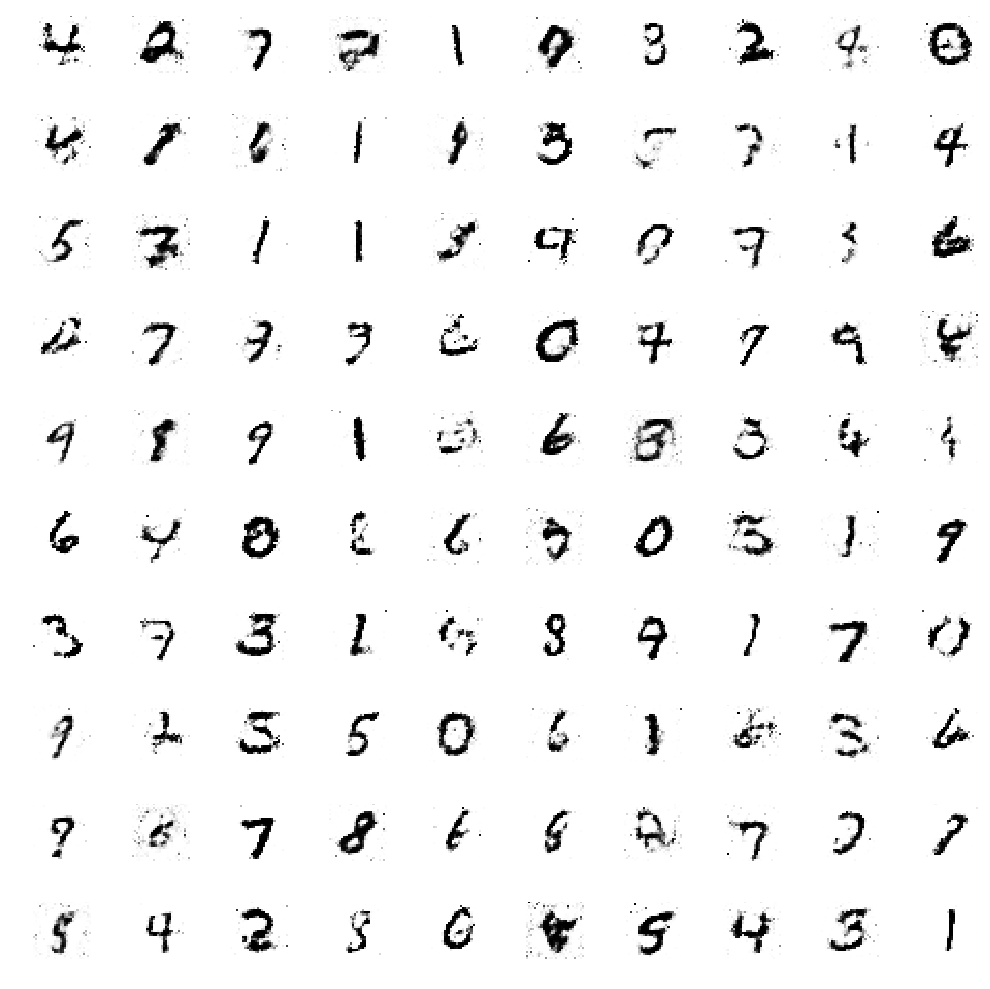

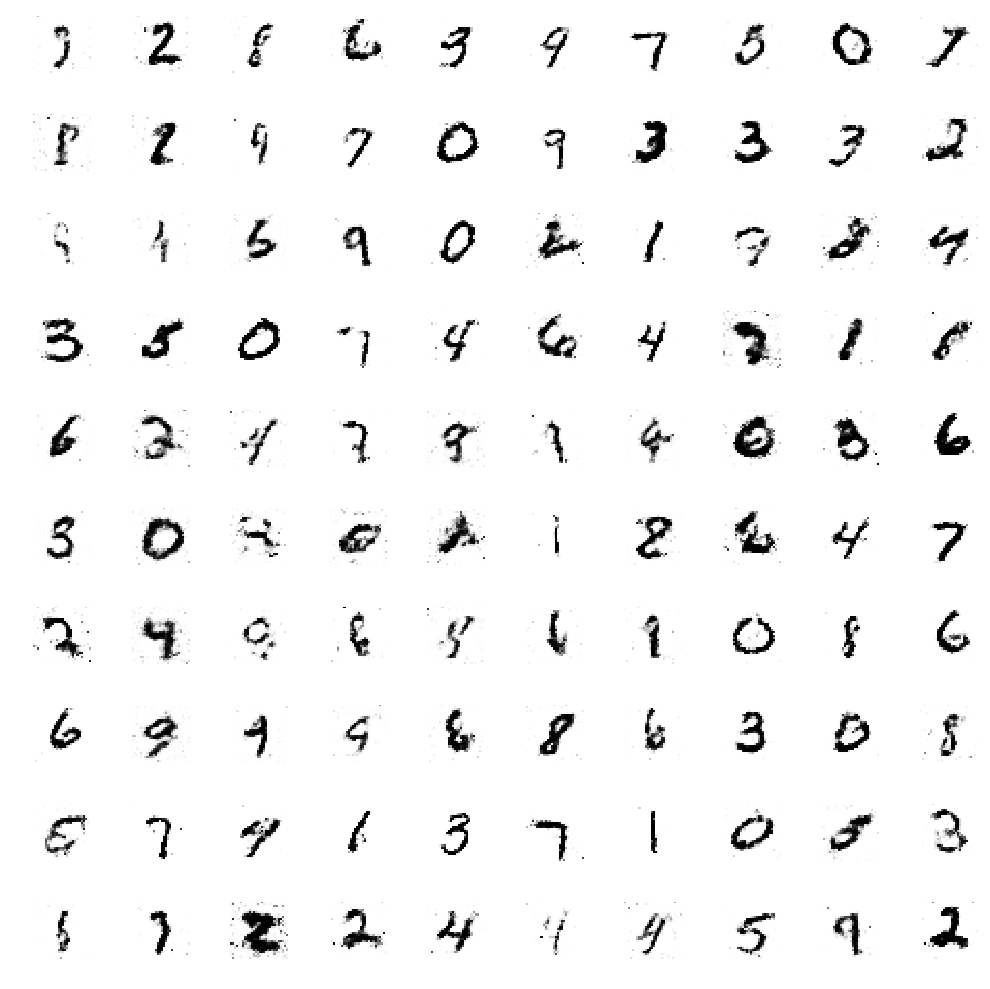

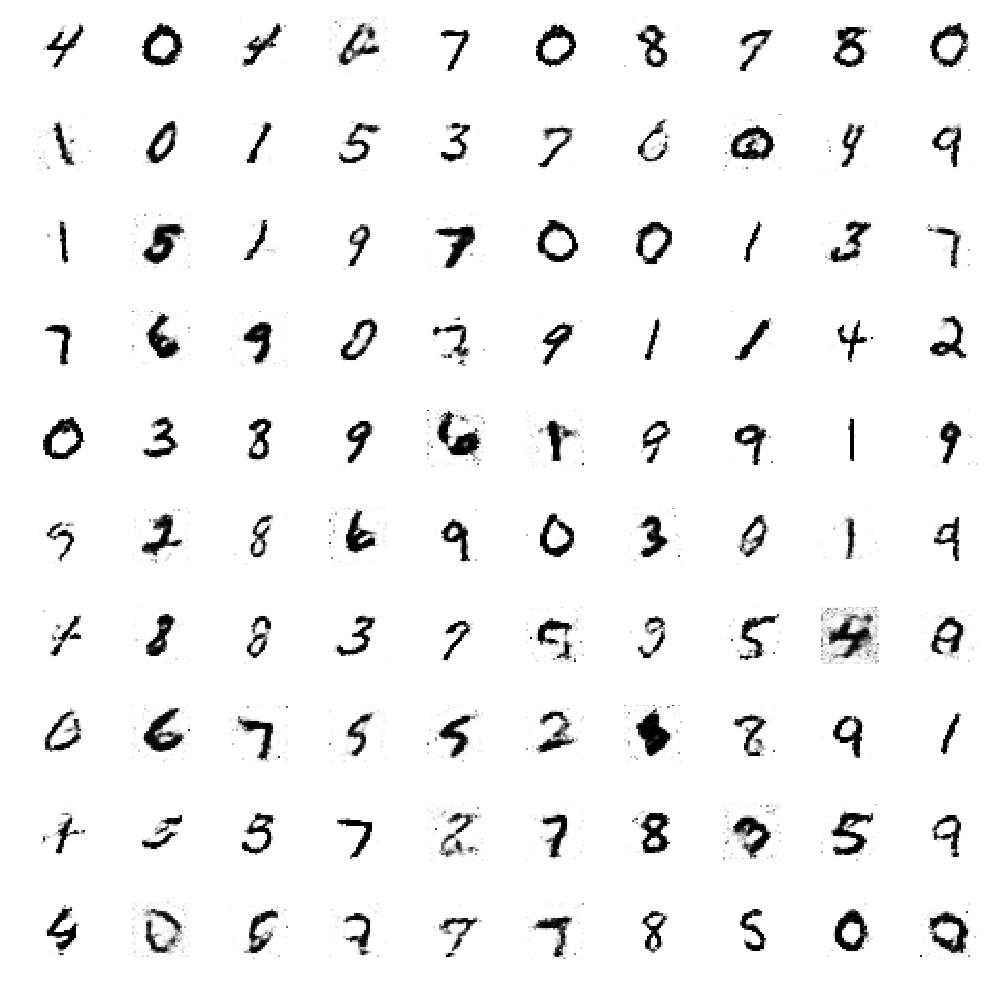

In [17]:
train(50, 128)